# B.Tech Project

## Unsupervised Deep Learning for Denoising Images
### Boosting denoisers with reinforcement learning for image restoration

    Ayush Abrol B20AI052
    Aryan Tiwari B20AI056

---

### Objective :

This Bachelor of Technology project aims to implement a novel method for image restoration using deep reinforcement learning, which casts the image restoration problem as a Partially Observable Markov Decision Process (POMDP) and allows for multiple pixel-wise image denoising operations. We aim to demonstrate the effectiveness of their approach through extensive experiments and show that it performs comparably or better than previous learning-based approaches.

### Necessary Imports

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import absolute_import
from builtins import *  
from future import standard_library
standard_library.install_aliases()  
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import cv2
import sys
import math
import time
import copy
from logging import getLogger
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as IPImage
from IPython.display import display

from chainer import serializers
from chainer import cuda, optimizers, Variable
import chainerrl
import chainer
import chainer.links as L
import chainer.functions as F
from chainer.links.caffe import CaffeFunction
from chainerrl.agents import a3c
from chainerrl import agent
from chainerrl.misc import async_
from chainerrl.misc.batch_states import batch_states
from chainerrl.misc import copy_param
from chainerrl.recurrent import Recurrent
from chainerrl.recurrent import RecurrentChainMixin
from chainerrl.recurrent import state_kept

from chainerrl.agents.a3c import A3CModel
import chainerrl
from cached_property import cached_property

### Checking GPU config

In [2]:
!nvidia-smi

Sat Jan  6 13:01:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 T...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0               10W /  N/A|      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Setting the device to GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Creating the Image DataLoader (BSD68 Dataset)

The code is primarily designed for loading image data, offering augmentation for training, and handling single image inference. It relies heavily on OpenCV (`cv2`) for image processing tasks like reading, resizing, and augmentation.

1. **Initialization:**
   - The constructor (`__init__`) initializes the `MiniBatchLoader` object with paths to training and testing data, along with an image directory path and a crop size.

2. **Static Methods:**
   - `path_label_generator`: Generates pairs of file paths by reading a text file (with paths) and joining them with a specified source path.
   - `count_paths`: Counts the number of paths in a given file.
   - `read_paths`: Uses `path_label_generator` to read paths from a text file and source path, returning a list of paths.

3. **Loading Data:**
   - `load_training_data` and `load_testing_data` methods take indices and call the `load_data` method with the respective dataset information (training/testing).
   - `load_data`:
     - Loads images using OpenCV (`cv2`) based on provided indices and path information.
     - If `augment` is set to True, it performs data augmentation (random flipping, rotation) on the images and resizes them to a specified crop size.
     - Images are normalized (scaled between 0 and 1) and stored in an array (`xs`) structured to fit a mini-batch.

4. **Conditions:**
   - There's a condition to handle different scenarios:
     - `augment=True`: When augmenting data for training.
     - `mini_batch_size == 1`: For single image inference.
     - Otherwise, it raises an error if the mini-batch size is not 1 during inference.


In [2]:
class MiniBatchLoader(object):
    def __init__(self, train_path, test_path, image_dir_path, crop_size):
        # Initialize paths and parameters
        self.training_path_infos = self.read_paths(train_path, image_dir_path)  # Paths for training data
        self.testing_path_infos = self.read_paths(test_path, image_dir_path)    # Paths for testing data
        self.crop_size = crop_size  # Size for cropping images
        
    @staticmethod
    def path_label_generator(txt_path, src_path):
        # Generator function to yield file paths based on text file input
        for line in open(txt_path):
            line = line.strip()
            src_full_path = os.path.join(src_path, line)
            if os.path.isfile(src_full_path):
                yield src_full_path
 
    @staticmethod
    def count_paths(path):
        # Counts the number of paths in a given file
        c = 0
        for _ in open(path):
            c += 1
        return c
 
    @staticmethod
    def read_paths(txt_path, src_path):
        # Read and collect paths using path_label_generator
        cs = []
        for pair in MiniBatchLoader.path_label_generator(txt_path, src_path):
            cs.append(pair)
        return cs
 
    def load_training_data(self, indices):
        # Load training data based on provided indices
        return self.load_data(self.training_path_infos, indices, self.crop_size, augment=True)
 
    def load_testing_data(self, indices):
        # Load testing data based on provided indices
        return self.load_data(self.testing_path_infos, indices, self.crop_size)
    
    def load_data(self, path_infos, indices, crop_size, augment=False):
        # Load data based on indices, crop images, and potentially augment
        
        mini_batch_size = len(indices)  # Determine mini-batch size
        in_channels = 1  # Number of image channels
        
        if augment:
            # If augment is True, prepare arrays to store augmented images
            xs = np.zeros((mini_batch_size, in_channels, crop_size, crop_size)).astype(np.float32)
            
            for i, index in enumerate(indices):
                path = path_infos[index]  # Get the path based on index
                
                img = cv2.imread(path, 0)  # Read image in grayscale
                if img is None:
                    raise RuntimeError("invalid image: {i}".format(i=path))
                
                # Apply random augmentations (flip, rotation)
                if np.random.rand() > 0.5:
                    img = np.fliplr(img)

                if np.random.rand() > 0.5:
                    angle = 10 * np.random.rand()
                    if np.random.rand() > 0.5:
                        angle *= -1
                    # Rotate the image
                    M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1)
                    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

                # Resize the image to crop_size x crop_size
                img = cv2.resize(img, (crop_size, crop_size), interpolation=cv2.INTER_AREA)
                
                # Normalize image and store in the xs array
                xs[i, 0, :, :] = (img / 255).astype(np.float32)

        elif mini_batch_size == 1:
            # If mini-batch size is 1, process a single image
            for i, index in enumerate(indices):
                path = path_infos[index]  # Get the path based on index
                
                img = cv2.imread(path, 0)  # Read image in grayscale
                if img is None:
                    raise RuntimeError("invalid image: {i}".format(i=path))

                # Resize the image to crop_size x crop_size
                h, w = img.shape
                img = cv2.resize(img, (crop_size, crop_size), interpolation=cv2.INTER_AREA)
                
                # Prepare xs array for a single image and normalize it
                xs = np.zeros((mini_batch_size, in_channels, crop_size, crop_size)).astype(np.float32)
                xs[0, 0, :, :] = (img / 255).astype(np.float32)
        
        else:
            # Error handling if mini-batch size is not 1 during inference
            raise RuntimeError("Mini Batch size must be 1 while inference")
 
        return xs  # Return the processed images in an array

### Setting Hyperparameters and paths

In [93]:
train_path = 'training_BSD68.txt'
test_path = 'testing.txt'
image_dir_path = './'
crop_size_ = 248

In [94]:
SAVE_PATH = "./save_path"
LEARNING_RATE = 0.001
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1
N_EPISODES = 30000
EPISODE_LEN = 5
SNAPSHOT_EPISODES = 300
TEST_EPISODES = 300
GAMMA = 0.95 
MEAN = 0
SIGMA = 15
N_ACTIONS = 6
MOVE_RANGE = 3
GPU_ID = 0

In [100]:
action_color_map = {
    0: 'gray',
    1: 'brown',
    2: 'aqua',
    3: 'navy',
    4: 'violet',
    5: 'red'
}

### Load Data

In [95]:
# Initialize the mini-batch loader
mini_batch_loader = MiniBatchLoader(train_path, test_path, image_dir_path, crop_size_)

In [6]:
# Get data size
train_data_size = MiniBatchLoader.count_paths(train_path)
train_data_size

432

In [7]:
# Get Shuffled indices for training data
indices = np.random.permutation(train_data_size)
indices

array([113, 188,  34, 381, 333, 402, 275,  18, 131, 271, 351, 265, 260,
       296, 209, 231,   9, 177, 375, 336, 344, 334, 183, 114, 274, 325,
       258, 126,  29, 191,  25,  46,  87,  41,   1, 247, 120, 192, 235,
       181, 207, 229,  60, 160, 305, 178, 107,  23, 151,  62, 158, 304,
       314, 203,  70, 397, 111,  16,  89, 166, 118, 373, 388, 416, 287,
        44, 143, 137, 182, 173, 419, 255,  74, 384, 172,  53, 299, 285,
       225, 128,  78, 174, 171, 259, 326, 163, 115,  77, 411,  54,  65,
       268, 176, 329, 239, 269,  64, 331, 145, 421,  48, 376, 328, 208,
       147, 430, 340,  42,  69, 196, 361, 293, 413, 341, 175, 300,  35,
        56,  12, 261, 358, 264, 312, 110, 262,  76, 400, 389,  75, 401,
       108, 236, 374, 390,  22,  19, 257, 217, 213, 248,  14, 289, 136,
       197, 378, 273,  37,  51, 129, 199, 253, 408, 369, 352, 200, 202,
       133, 240, 101,  27, 224, 216, 308, 232,  59,  88, 142, 353, 180,
        52, 214, 149, 406, 103,  67, 135, 222, 392,  30, 282,  5

In [8]:
# Load training data using the indices
data = mini_batch_loader.load_training_data(indices)
data

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0

In [9]:
# Visualize the first 32 images
data_to_visualize = data[0:32]
data_to_visualize

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0

In [10]:
data_to_visualize.shape

(32, 1, 248, 248)

### Visualizing the dataset

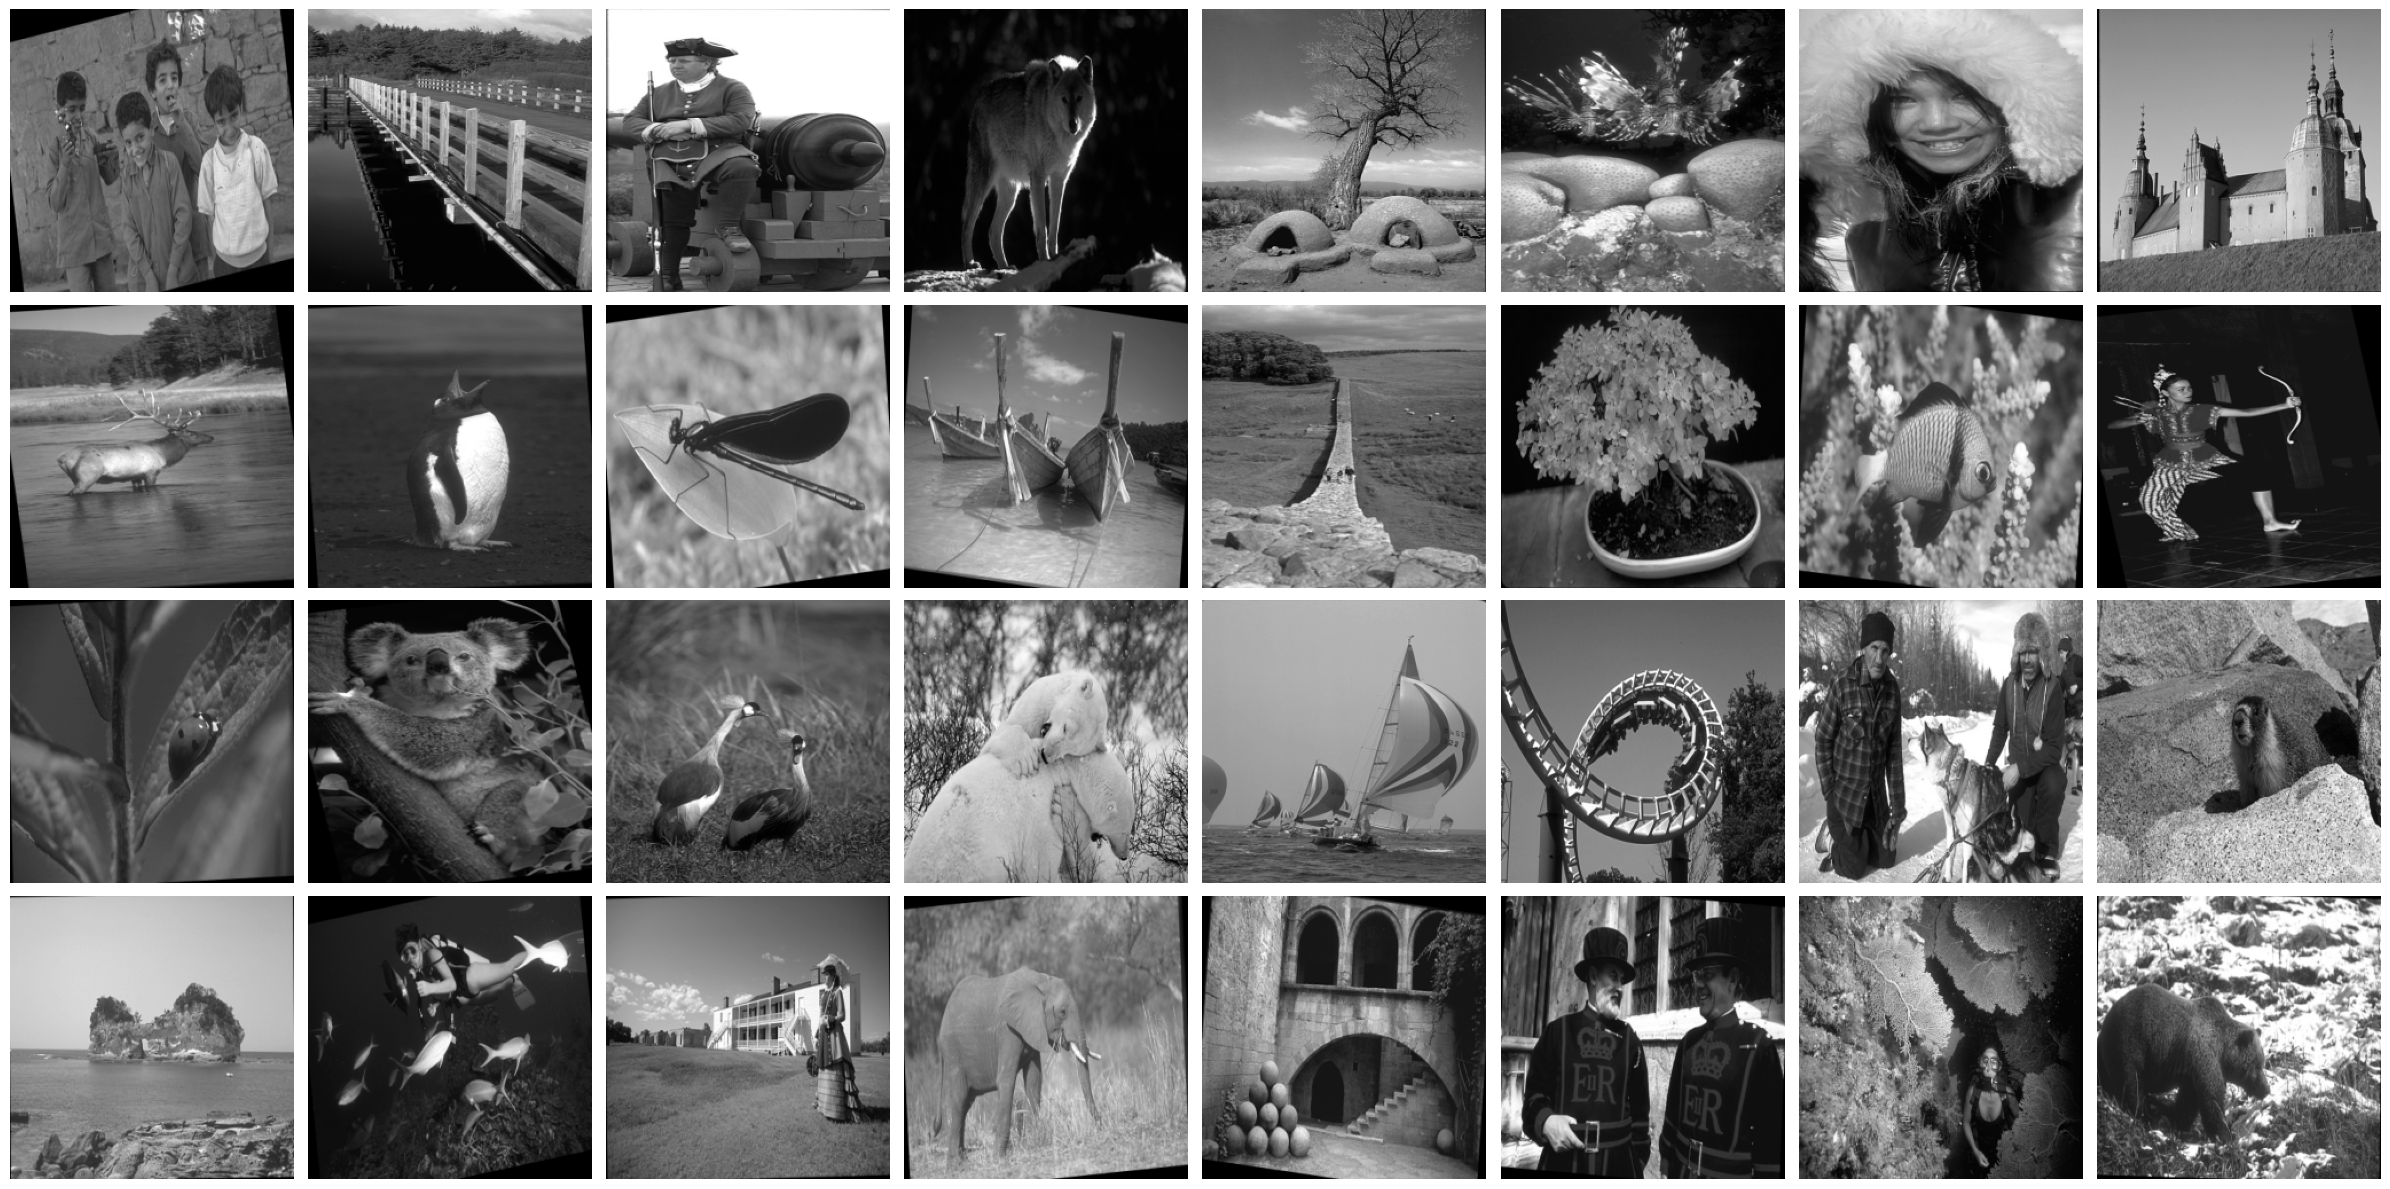

In [13]:
num_images = len(data_to_visualize)
num_rows = 4  # Define the number of rows in the grid
num_cols = 8  # Define the number of columns in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < num_images:
            img_to_show = data_to_visualize[index, 0, :, :]  # Assuming single-channel images
            axes[i, j].imshow(img_to_show, cmap='gray')  # Assuming grayscale images
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')  # Hide axes for empty subplots

plt.tight_layout()
plt.show()

### Sample image without adding noise

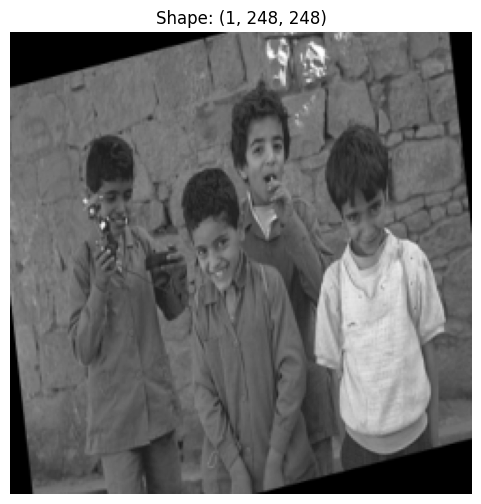

In [14]:
idx = 0

data_to_visualize[idx]

plt.figure(figsize=(6, 6))
img_to_show = data_to_visualize[0, 0, :, :]
plt.imshow(img_to_show, cmap='gray')  
plt.axis('off')
plt.title(f"Shape: {data_to_visualize[0].shape}")  
plt.show()

### Networks

The `State` class represents an environment state that manages image manipulation based on specified actions. The class provides methods to reset the state, set a new image, and update the state based on actions taken in the environment.

**Initialization (`__init__`):**

- Initializes a `State` object with an image of zeros with a specific size and a move range value.

**Method `reset`:**

- Resets the state with a new image `x` added to a value `n`.
- Constructs a tensor by concatenating the current image (`self.image`) with a zero-filled array (`prev_state`) along the second axis.

**Method `set`:**

- Sets the state's image to a new input `x`.
- Updates the tensor's initial section to reflect the new image.

**Method `step`:**

- Takes an action `act` and an inner state.
- Processes the action and manipulates the current image based on the action taken:
  - Scales the action values to a range and applies the movement to the image.
  - Applies various image manipulation filters (like Gaussian blur, bilateral filter, median blur, etc.) to different regions of the image based on the action taken (`act` values).
  - Updates the current image based on the actions performed using the filters.
  - Updates the tensor with the new modified image and inner state.


In [96]:
class State():
    def __init__(self, size, move_range):
        self.image = np.zeros(size,dtype=np.float32)
        self.move_range = move_range
    
    def reset(self, x, n):
        self.image = x+n
        size = self.image.shape
        prev_state = np.zeros((size[0],64,size[2],size[3]),dtype=np.float32)
        self.tensor = np.concatenate((self.image, prev_state), axis=1)

    def set(self, x):
        self.image = x
        self.tensor[:,:self.image.shape[1],:,:] = self.image

    def step(self, act, inner_state, i_, t_, fout2, action_color_map):
        neutral = (self.move_range - 1)/2
        move = act.astype(np.float32)
        move = (move - neutral)/255
        moved_image = self.image + move[:,np.newaxis,:,:]
        gaussian = np.zeros(self.image.shape, self.image.dtype)
        gaussian2 = np.zeros(self.image.shape, self.image.dtype)
        bilateral = np.zeros(self.image.shape, self.image.dtype)
        bilateral2 = np.zeros(self.image.shape, self.image.dtype)
        median = np.zeros(self.image.shape, self.image.dtype)
        box = np.zeros(self.image.shape, self.image.dtype)
        b, c, h, w = self.image.shape
        for i in range(0,b):
            if np.sum(act[i]==self.move_range) > 0:
                gaussian[i,0] = cv2.GaussianBlur(self.image[i,0], ksize=(5,5), sigmaX=0.5)
            if np.sum(act[i]==self.move_range+1) > 0:
                bilateral[i,0] = cv2.bilateralFilter(self.image[i,0], d=5, sigmaColor=0.1, sigmaSpace=5)
            if np.sum(act[i]==self.move_range+2) > 0:
                median[i,0] = cv2.medianBlur(self.image[i,0], ksize=5)
            if np.sum(act[i]==self.move_range+3) > 0:
                gaussian2[i,0] = cv2.GaussianBlur(self.image[i,0], ksize=(5,5), sigmaX=1.5)
            if np.sum(act[i]==self.move_range+4) > 0:
                bilateral2[i,0] = cv2.bilateralFilter(self.image[i,0], d=5, sigmaColor=1.0, sigmaSpace=5)
            if np.sum(act[i]==self.move_range+5) > 0:
                box[i,0] = cv2.boxFilter(self.image[i,0], ddepth=-1, ksize=(5,5))

        fout2.write("Agent action for image " + str(i_) + " at time step " + str(t_) + ": " + str(act) + "\n")
        fout2.write("Shape of the action: " + str(act.shape) + "\n")
        print("Agent action for image " + str(i_) + " at time step " + str(t_) + ": " + str(act))
        print("Shape of the action: " + str(act.shape))
        sys.stdout.flush()
        # Create an image for agent action of 1x248x248 according to the colors of the action
        color_map = np.zeros((248, 248, 3), dtype=np.uint8)
        for i in range(248):
            for j in range(248):
                color = action_color_map[act[0, i, j]]
                if color == 'gray':
                    color_map[i, j] = [128, 128, 128]  # RGB values for gray
                elif color == 'brown':
                    color_map[i, j] = [165, 42, 42]    # RGB values for brown
                elif color == 'aqua':
                    color_map[i, j] = [0, 255, 255]    # RGB values for aqua
                elif color == 'navy':
                    color_map[i, j] = [0, 0, 128]     # RGB values for navy
                elif color == 'violet':
                    color_map[i, j] = [238, 130, 238]  # RGB values for violet
                elif color == 'red':
                    color_map[i, j] = [255, 0, 0]     # RGB values for red
        
        if not os.path.exists('./action_maps_test/' + str(i_)):
            os.makedirs('./action_maps_test/' + str(i_))
        
        # Save the image
        cv2.imwrite('./action_maps_test/' + str(i_) + '/' + 'episode_' + str(t_) + '.png', color_map)

        self.image = moved_image
        self.image = np.where(act[:,np.newaxis,:,:]==self.move_range, gaussian, self.image)
        self.image = np.where(act[:,np.newaxis,:,:]==self.move_range+1, bilateral, self.image)
        self.image = np.where(act[:,np.newaxis,:,:]==self.move_range+2, median, self.image)
        self.image = np.where(act[:,np.newaxis,:,:]==self.move_range+3, gaussian2, self.image)
        self.image = np.where(act[:,np.newaxis,:,:]==self.move_range+4, bilateral2, self.image)
        self.image = np.where(act[:,np.newaxis,:,:]==self.move_range+5, box, self.image)

        self.tensor[:,:self.image.shape[1],:,:] = self.image
        self.tensor[:,-64:,:,:] = inner_state

In [12]:
class DilatedConvBlock(chainer.Chain):

    def __init__(self, d_factor, weight, bias):
        super(DilatedConvBlock, self).__init__(
            diconv=L.DilatedConvolution2D( in_channels=64, out_channels=64, ksize=3, stride=1, pad=d_factor, dilate=d_factor, nobias=False, initialW=weight, initial_bias=bias),
            #bn=L.BatchNormalization(64)
        )

        self.train = True

    def __call__(self, x):
        h = F.relu(self.diconv(x))
        #h = F.relu(self.bn(self.diconv(x)))
        return h

This class represents a neural network architecture with convolutional, dilated convolutional, and recurrent-like connections used for both policy and value estimation in reinforcement learning task that we are doing.

**Constructor (`__init__`) Method:**

- It initializes the model and sets up its layers.
- `n_actions` is the number of actions the model can output.
- The model loads weights from a Caffe model (`CaffeFunction`) to initialize certain layers.
- It creates multiple layers including:
  - Convolutional layers (`L.Convolution2D`)
  - `DilatedConvBlock` instances (`DilatedConvBlock`)
  - Recurrent-like connections using convolutions (`conv7_*` connections).
  - A softmax policy layer (`conv8_pi`) for outputting action probabilities.
  - Additional dilated convolutional layers (`diconv5_V`, `diconv6_V`) and a final convolutional layer (`conv7_V`) for value estimation.

**`pi_and_v` Method:**

- This method defines the forward pass of the model.
- It takes input `x`, applies a series of operations:
  - Initial convolution (`conv1`) followed by ReLU activation.
  - Multiple dilated convolutions (`diconv2`, `diconv3`, `diconv4`, `diconv5_pi`, `diconv6_pi`).
  - Calculation of intermediate variables (`x_t`, `h_t1`, `z_t`, `r_t`, `h_tilde_t`, `h_t`) using convolutions and sigmoid/tanh activations.
  - Output calculation for policy (`pout`) using `conv8_pi`.
  - Value estimation (`vout`) using dilated convolutional layers (`diconv5_V`, `diconv6_V`) and a final convolution (`conv7_V`).


In [13]:
class MyFcn(chainer.Chain, a3c.A3CModel):
 
    def __init__(self, n_actions):
        w = chainer.initializers.HeNormal()
        net = CaffeFunction('./initial_weight/zhang_cvpr17_denoise_15_gray.caffemodel')
        super(MyFcn, self).__init__(
            conv1=L.Convolution2D( 1, 64, 3, stride=1, pad=1, nobias=False, initialW=net.layer1.W.data, initial_bias=net.layer1.b.data),
            diconv2=DilatedConvBlock(2, net.layer3.W.data, net.layer3.b.data),
            diconv3=DilatedConvBlock(3, net.layer6.W.data, net.layer6.b.data),
            diconv4=DilatedConvBlock(4, net.layer9.W.data, net.layer9.b.data),
            diconv5_pi=DilatedConvBlock(3, net.layer12.W.data, net.layer12.b.data),
            diconv6_pi=DilatedConvBlock(2, net.layer15.W.data, net.layer15.b.data),
            conv7_Wz=L.Convolution2D( 64, 64, 3, stride=1, pad=1, nobias=True, initialW=w),
            conv7_Uz=L.Convolution2D( 64, 64, 3, stride=1, pad=1, nobias=True, initialW=w),
            conv7_Wr=L.Convolution2D( 64, 64, 3, stride=1, pad=1, nobias=True, initialW=w),
            conv7_Ur=L.Convolution2D( 64, 64, 3, stride=1, pad=1, nobias=True, initialW=w),
            conv7_W=L.Convolution2D( 64, 64, 3, stride=1, pad=1, nobias=True, initialW=w),
            conv7_U=L.Convolution2D( 64, 64, 3, stride=1, pad=1, nobias=True, initialW=w),
            conv8_pi=chainerrl.policies.SoftmaxPolicy(L.Convolution2D( 64, n_actions, 3, stride=1, pad=1, nobias=False, initialW=w)),
            diconv5_V=DilatedConvBlock(3, net.layer12.W.data, net.layer12.b.data),
            diconv6_V=DilatedConvBlock(2, net.layer15.W.data, net.layer15.b.data),
            conv7_V=L.Convolution2D( 64, 1, 3, stride=1, pad=1, nobias=False, initialW=net.layer18.W.data, initial_bias=net.layer18.b.data),
        )
        self.train = True
 
    def pi_and_v(self, x):
         
        h = F.relu(self.conv1(x[:,0:1,:,:]))
        h = self.diconv2(h)
        h = self.diconv3(h)
        h = self.diconv4(h)
        h_pi = self.diconv5_pi(h)
        x_t = self.diconv6_pi(h_pi)
        h_t1 = x[:,-64:,:,:]
        z_t = F.sigmoid(self.conv7_Wz(x_t)+self.conv7_Uz(h_t1))
        r_t = F.sigmoid(self.conv7_Wr(x_t)+self.conv7_Ur(h_t1))
        h_tilde_t = F.tanh(self.conv7_W(x_t)+self.conv7_U(r_t*h_t1))
        h_t = (1-z_t)*h_t1+z_t*h_tilde_t
        pout = self.conv8_pi(h_t)

        h_V = self.diconv5_V(h)
        h_V = self.diconv6_V(h_V)
        vout = self.conv7_V(h_V)
       
        return pout, vout, h_t

In [14]:
logger = getLogger(__name__)

Function for computing the entropy of a probability distribution using Chainer:

- `@cached_property`: Caches the result for efficient future access.
- `with chainer.force_backprop_mode()`: Enables backpropagation even during inference.
- `F.sum(self.all_prob * self.all_log_prob, axis=1)`: Calculates the sum of probabilities multiplied by their respective log probabilities along each data point.
- `return F.stack([- F.sum(self.all_prob * self.all_log_prob, axis=1)], axis=1)`: Negates this sum and structures it into a tensor, representing the entropy values for the given probability distribution.


In [15]:
@cached_property
def myentropy(self):
    with chainer.force_backprop_mode():
        return F.stack([- F.sum(self.all_prob * self.all_log_prob, axis=1)], axis=1)

This function, `mylog_prob`, reshapes and selects specific log probabilities:

- **Inputs**: `self.all_log_prob` holds log probabilities, and `x` is input indices.
- **Logic**:
  - Extracts dimensions from `self.all_log_prob`.
  - Transposes and reshapes the log probabilities for selection.
  - Reshapes the input indices for selection.
  - Uses `F.select_item()` to pick log probabilities based on indices.
  - Reshapes the selected log probabilities to the original batch shape.
- **Return**: Returns the selected log probabilities reshaped to match the original batch shape.


In [16]:
def mylog_prob(self, x):
    n_batch, n_actions, h, w = self.all_log_prob.shape
    p_trans = F.transpose(self.all_log_prob, axes=(0,2,3,1))
    p_trans = F.reshape(p_trans,(-1,n_actions))
    x_reshape = F.reshape(x,(1,-1))[0]
    selected_p = F.select_item(p_trans,x_reshape)
    return F.reshape(selected_p, (n_batch,1,h,w))

This class represents an A3C agent capable of asynchronous training and acting, gathering experiences, updating models, and handling episode terminations in reinforcement learning scenarios.

**Initialization:**

- It initializes the A3C agent with various hyperparameters like learning rate, discount factor, and others.
- Sets up two models: `shared_model` (global) and `model` (thread-specific) using `deepcopy`.
- Initializes optimizer and other variables used for tracking past actions, rewards, and states.

**`update` Method:**

- Updates the model based on accumulated experiences (rewards, actions, values).
- Computes policy and value losses (`pi_loss`, `v_loss`), adjusts them based on coefficients and normalization.
- Performs backpropagation, updates the shared model, and synchronizes parameters.

**`act_and_train` Method:**

- Performs an action in the environment, collecting experiences.
- Updates the model when a certain number of experiences (`t_max`) is reached.
- Samples an action based on policy (`pout`) and collects action log probabilities and entropy.
- Updates internal counters and returns the selected action and inner state.

**`act` Method:**

- Similar to `act_and_train` but used for acting without training.
- Samples an action based on policy (`pout`) and returns it along with the inner state.

**Episode Handling:**

- `stop_episode_and_train` and `stop_episode` manage episode endings, resetting states if necessary.

**Other Methods:**

- Includes methods for loading models and gathering statistics.

In [17]:
class PixelWiseA3C_InnerState(agent.AttributeSavingMixin, agent.AsyncAgent):

    process_idx = None
    saved_attributes = ['model', 'optimizer']

    def __init__(self, model, optimizer, t_max, gamma, beta=1e-2,
                 process_idx=0, phi=lambda x: x,
                 pi_loss_coef=1.0, v_loss_coef=0.5,
                 keep_loss_scale_same=False,
                 normalize_grad_by_t_max=False,
                 use_average_reward=False, average_reward_tau=1e-2,
                 act_deterministically=False,
                 average_entropy_decay=0.999,
                 average_value_decay=0.999,
                 batch_states=batch_states):

        assert isinstance(model, A3CModel)
        # Globally shared model
        self.shared_model = model

        # Thread specific model
        self.model = copy.deepcopy(self.shared_model)
        async_.assert_params_not_shared(self.shared_model, self.model)

        self.optimizer = optimizer

        self.t_max = t_max
        self.gamma = gamma
        self.beta = beta
        self.phi = phi
        self.pi_loss_coef = pi_loss_coef
        self.v_loss_coef = v_loss_coef
        self.keep_loss_scale_same = keep_loss_scale_same
        self.normalize_grad_by_t_max = normalize_grad_by_t_max
        self.use_average_reward = use_average_reward
        self.average_reward_tau = average_reward_tau
        self.act_deterministically = act_deterministically
        self.average_value_decay = average_value_decay
        self.average_entropy_decay = average_entropy_decay
        self.batch_states = batch_states

        self.t = 0
        self.t_start = 0
        self.past_action_log_prob = {}
        self.past_action_entropy = {}
        self.past_states = {}
        self.past_rewards = {}
        self.past_values = {}
        self.average_reward = 0
        # A3C won't use a explorer, but this arrtibute is referenced by run_dqn
        self.explorer = None

        # Stats
        self.average_value = 0
        self.average_entropy = 0


        self.shared_model.to_gpu()
        chainerrl.distribution.CategoricalDistribution.mylog_prob = mylog_prob
        chainerrl.distribution.CategoricalDistribution.myentropy = myentropy

    def sync_parameters(self):
        copy_param.copy_param(target_link=self.model,
                              source_link=self.shared_model)

    @property
    def shared_attributes(self):
        return ('shared_model', 'optimizer')

    def update(self, statevar):
        assert self.t_start < self.t

        if statevar is None:
            R = 0
        else:
            with state_kept(self.model):
                _, vout, __ = self.model.pi_and_v(statevar)
            R = F.cast(vout.data, 'float32')

        pi_loss = 0
        v_loss = 0
        for i in reversed(range(self.t_start, self.t)):
            R *= self.gamma
            R += self.past_rewards[i]
            if self.use_average_reward:
                R -= self.average_reward
            v = self.past_values[i]
            advantage = R - v
            if self.use_average_reward:
                self.average_reward += self.average_reward_tau * \
                    float(advantage.data)
            # Accumulate gradients of policy
            log_prob = self.past_action_log_prob[i]
            entropy = self.past_action_entropy[i]

            pi_loss -= log_prob * F.cast(advantage.data, 'float32')

            pi_loss -= self.beta * entropy
            v_loss += (v - R) ** 2 / 2

        if self.pi_loss_coef != 1.0:
            pi_loss *= self.pi_loss_coef

        if self.v_loss_coef != 1.0:
            v_loss *= self.v_loss_coef

        if self.keep_loss_scale_same and \
                self.t - self.t_start < self.t_max:
            factor = self.t_max / (self.t - self.t_start)
            pi_loss *= factor
            v_loss *= factor

        if self.normalize_grad_by_t_max:
            pi_loss /= self.t - self.t_start
            v_loss /= self.t - self.t_start

        if self.process_idx == 0:
            logger.debug('pi_loss:%s v_loss:%s', pi_loss.data, v_loss.data)

        total_loss = F.mean(pi_loss + F.reshape(v_loss, pi_loss.data.shape))

        self.model.zerograds()
        total_loss.backward()
        self.shared_model.zerograds()
        copy_param.copy_grad(
            target_link=self.shared_model, source_link=self.model)
        if self.process_idx == 0:
            norm = sum(np.sum(np.square(param.grad))
                       for param in self.optimizer.target.params())
            logger.debug('grad norm:%s', norm)
        self.optimizer.update()
        if self.process_idx == 0:
            logger.debug('update')

        self.sync_parameters()
        if isinstance(self.model, Recurrent):
            self.model.unchain_backward()

        self.past_action_log_prob = {}
        self.past_action_entropy = {}
        self.past_states = {}
        self.past_rewards = {}
        self.past_values = {}

        self.t_start = self.t

    def act_and_train(self, state, reward):
        statevar = chainer.cuda.to_gpu(state)

        self.past_rewards[self.t - 1] = chainer.cuda.to_gpu(reward)

        if self.t - self.t_start == self.t_max:
            self.update(statevar)

        self.past_states[self.t] = statevar
        pout, vout, inner_state = self.model.pi_and_v(statevar)
        action = pout.sample().data  
        self.past_action_log_prob[self.t] = pout.mylog_prob(action)
        self.past_action_entropy[self.t] = pout.myentropy
        self.past_values[self.t] = vout
        self.t += 1
        if self.process_idx == 0:
            logger.debug('t:%s r:%s a:%s pout:%s',
                         self.t, reward, action, pout)

        return chainer.cuda.to_cpu(action), chainer.cuda.to_cpu(inner_state.data)

    def act(self, obs):
        with chainer.no_backprop_mode():
            statevar = chainer.cuda.to_gpu(obs)
            pout, _, inner_state = self.model.pi_and_v(statevar)
            if self.act_deterministically:
                return chainer.cuda.to_cpu(pout.most_probable.data), chainer.cuda.to_cpu(inner_state.data)
            else:
                return chainer.cuda.to_cpu(pout.sample().data), chainer.cuda.to_cpu(inner_state.data)


    def stop_episode_and_train(self, state, reward, done=False):
        self.past_rewards[self.t - 1] = chainer.cuda.to_gpu(reward)
        if done:
            self.update(None)
        else:
            statevar = chainer.cuda.to_gpu(state)
            self.update(statevar)

        if isinstance(self.model, Recurrent):
            self.model.reset_state()

    def stop_episode(self):
        if isinstance(self.model, Recurrent):
            self.model.reset_state()

    def load(self, dirname):
        super().load(dirname)
        copy_param.copy_param(target_link=self.shared_model,
                              source_link=self.model)

    def get_statistics(self):
        return [
            ('average_value', self.average_value),
            ('average_entropy', self.average_entropy),
        ]

### Training the policy and value network

In [18]:
mini_batch_loader = MiniBatchLoader(
    train_path=train_path,
    test_path=test_path,
    image_dir_path=image_dir_path,
    crop_size=crop_size_
)

In [19]:
chainer.cuda.get_device_from_id(GPU_ID).use()

<CUDA Device 0>

In [20]:
current_state = State((TRAIN_BATCH_SIZE,1,crop_size_,crop_size_), MOVE_RANGE)

In [21]:
model = MyFcn(N_ACTIONS)

c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python311\Lib\site-packages\chainer\links\caffe\caffe_function.py:164: UserWarning: Skip the layer "input", since CaffeFunction does notsupport Input layer
  warnings.warn(


In [22]:
optimizer = chainer.optimizers.Adam(alpha=LEARNING_RATE)
optimizer.setup(model)

In [23]:
agent = PixelWiseA3C_InnerState(model, optimizer, EPISODE_LEN, GAMMA)
agent.model.to_gpu()

In [299]:
fout = open('log15_train.txt', "w")

In [300]:
def test(loader, agent, fout, episode):
    
    if not os.path.exists('./episode_wise_images/' + str(episode)):
        os.makedirs('./episode_wise_images/' + str(episode))

    sum_psnr = 0
    sum_reward = 0
    test_data_size = MiniBatchLoader.count_paths(test_path)
    current_state = State((TEST_BATCH_SIZE,1,crop_size_,crop_size_), MOVE_RANGE)
    for i in range(0, test_data_size, TEST_BATCH_SIZE):
        raw_x = loader.load_testing_data(np.array(range(i, i+TEST_BATCH_SIZE)))
        raw_n = np.random.normal(MEAN,SIGMA,raw_x.shape).astype(raw_x.dtype)/255
        current_state.reset(raw_x,raw_n)
        reward = np.zeros(raw_x.shape, raw_x.dtype)*255
        
        for t in range(0, EPISODE_LEN):
            previous_image = current_state.image.copy()
            action, inner_state = agent.act(current_state.tensor)
            current_state.step(action, inner_state)
            reward = np.square(raw_x - previous_image)*255 - np.square(raw_x - current_state.image)*255
            sum_reward += np.mean(reward)*np.power(GAMMA,t)

        agent.stop_episode()
            
        I = np.maximum(0,raw_x)
        I = np.minimum(1,I)
        p = np.maximum(0,current_state.image)
        p = np.minimum(1,p)
        I = (I*255+0.5).astype(np.uint8)
        p = (p*255+0.5).astype(np.uint8)

        # Save images obtained by the agent
        cv2.imwrite('./episode_wise_images/' + str(episode) + '/' + str(i) + '_I.png', p[0,0,:,:])

        sum_psnr += cv2.PSNR(p, I)

    print("test total reward {a}, PSNR {b}".format(a=sum_reward*255/test_data_size, b=sum_psnr/test_data_size))
    fout.write("test total reward {a}, PSNR {b}\n".format(a=sum_reward*255/test_data_size, b=sum_psnr/test_data_size))
    sys.stdout.flush()

In [301]:
start = time.time()
train_data_size = MiniBatchLoader.count_paths(train_path)
indices = np.random.permutation(train_data_size)
i = 0
for episode in range(1, N_EPISODES+1):
    # display current state
    print("episode %d" % episode)
    fout.write("episode %d\n" % episode)
    sys.stdout.flush()
    # load images
    r = indices[i:i+TRAIN_BATCH_SIZE]
    raw_x = mini_batch_loader.load_training_data(r)
    # generate noise
    raw_n = np.random.normal(MEAN,SIGMA,raw_x.shape).astype(raw_x.dtype)/255
    # initialize the current state and reward
    current_state.reset(raw_x,raw_n)
    reward = np.zeros(raw_x.shape, raw_x.dtype)
    sum_reward = 0
    
    for t in range(0, EPISODE_LEN):
        previous_image = current_state.image.copy()
        action, inner_state = agent.act_and_train(current_state.tensor, reward)
        current_state.step(action, inner_state)
        reward = np.square(raw_x - previous_image)*255 - np.square(raw_x - current_state.image)*255
        sum_reward += np.mean(reward)*np.power(GAMMA,t)

    agent.stop_episode_and_train(current_state.tensor, reward, True)
    print("train total reward {a}".format(a=sum_reward*255))
    fout.write("train total reward {a}\n".format(a=sum_reward*255))
    sys.stdout.flush()

    if episode % TEST_EPISODES == 0:
        #_/_/_/ testing _/_/_/
        test(mini_batch_loader, agent, fout, episode)

    if episode % SNAPSHOT_EPISODES == 0:
        agent.save('./save_path' + SAVE_PATH + str(episode))
    
    if i+TRAIN_BATCH_SIZE >= train_data_size:
        i = 0
        indices = np.random.permutation(train_data_size)
    else:        
        i += TRAIN_BATCH_SIZE

    if i+2*TRAIN_BATCH_SIZE >= train_data_size:
        i = train_data_size - TRAIN_BATCH_SIZE

    optimizer.alpha = LEARNING_RATE*((1-episode/N_EPISODES)**0.9)
end = time.time()

episode 1
train total reward -188.983459991388
episode 2
train total reward -107.7795287761786
episode 3
train total reward -33.98203928947238
episode 4
train total reward 1.1856889498693663
episode 5
train total reward 61.99540317729114
episode 6
train total reward 71.24459963899618
episode 7
train total reward 81.00057210358617
episode 8
train total reward 75.65484912669193
episode 9
train total reward 91.12331040471248
episode 10
train total reward 89.13051347083564
episode 11
train total reward 93.64400862772906
episode 12
train total reward 89.8653870642227
episode 13
train total reward 94.15388100518555
episode 14
train total reward 95.61701626481756
episode 15
train total reward 88.51060844974387
episode 16
train total reward 98.93044553470597
episode 17
train total reward 92.65294006051442
episode 18
train total reward 96.11397656289519
episode 19
train total reward 103.09770758771833
episode 20
train total reward 96.32973308374626
episode 21
train total reward 93.2224878455816

In [302]:
print("{s}[s]".format(s=end - start))
print("{s}[m]".format(s=(end - start)/60))
print("{s}[h]".format(s=(end - start)/60/60))
fout.write("{s}[s]\n".format(s=end - start))
fout.write("{s}[m]\n".format(s=(end - start)/60))
fout.write("{s}[h]\n".format(s=(end - start)/60/60))
fout.close()

44879.347427845[s]
747.9891237974167[m]
12.466485396623613[h]


### Testing the trained networks with test data

In [24]:
chainer.serializers.load_npz('save_path\save_path30000\model.npz', agent.model)
agent.act_deterministically = True
agent.model.to_gpu()

In [101]:
def test(loader, agent, fout, fout2, action_color_map):
    sum_psnr = 0
    sum_reward = 0
    test_data_size = MiniBatchLoader.count_paths(test_path)
    current_state = State((TEST_BATCH_SIZE,1,crop_size_,crop_size_), MOVE_RANGE)
    for i in range(0, test_data_size, TEST_BATCH_SIZE):
        raw_x = loader.load_testing_data(np.array(range(i, i+TEST_BATCH_SIZE)))
        raw_n = np.random.normal(MEAN,SIGMA,raw_x.shape).astype(raw_x.dtype)/255
        current_state.reset(raw_x,raw_n)
        reward = np.zeros(raw_x.shape, raw_x.dtype)*255
        
        for t in range(0, EPISODE_LEN):
            previous_image = current_state.image.copy()
            action, inner_state = agent.act(current_state.tensor)
            current_state.step(action, inner_state, i, t, fout2, action_color_map)
            reward = np.square(raw_x - previous_image)*255 - np.square(raw_x - current_state.image)*255
            sum_reward += np.mean(reward)*np.power(GAMMA,t)

        agent.stop_episode()
            
        I = np.maximum(0,raw_x)
        I = np.minimum(1,I)
        N = np.maximum(0,raw_x+raw_n)
        N = np.minimum(1,N)
        p = np.maximum(0,current_state.image)
        p = np.minimum(1,p)
        I = (I[0]*255+0.5).astype(np.uint8)
        N = (N[0]*255+0.5).astype(np.uint8)
        p = (p[0]*255+0.5).astype(np.uint8)
        p = np.transpose(p,(1,2,0))
        I = np.transpose(I,(1,2,0))
        N = np.transpose(N,(1,2,0))
        cv2.imwrite('./resultimage15/'+str(i)+'_output.png',p)
        cv2.imwrite('./resultimage15/'+str(i)+'_input.png',N)

        sum_psnr += cv2.PSNR(p, I)
 
    print("test total reward {a}, PSNR {b}".format(a=sum_reward*255/test_data_size, b=sum_psnr/test_data_size))
    fout.write("test total reward {a}, PSNR {b}\n".format(a=sum_reward*255/test_data_size, b=sum_psnr/test_data_size))
    sys.stdout.flush()

In [102]:
fout = open('log_test.txt', "w")
fout2 = open('agent_actions.txt', "w")

In [104]:
start = time.time()
test(mini_batch_loader, agent, fout, fout2, action_color_map)
end = time.time()

Agent action for image 0 at time step 0: [[[0 4 0 ... 3 3 3]
  [3 4 4 ... 3 3 3]
  [4 3 3 ... 3 3 3]
  ...
  [3 3 1 ... 4 0 4]
  [3 1 3 ... 3 3 2]
  [0 3 2 ... 3 3 0]]]
Shape of the action: (1, 248, 248)
Agent action for image 0 at time step 1: [[[0 0 3 ... 3 0 3]
  [0 4 4 ... 0 1 1]
  [4 3 3 ... 2 3 3]
  ...
  [2 4 0 ... 0 1 0]
  [0 0 2 ... 0 1 2]
  [0 0 2 ... 2 1 0]]]
Shape of the action: (1, 248, 248)
Agent action for image 0 at time step 2: [[[1 2 4 ... 0 0 0]
  [0 1 0 ... 0 3 3]
  [2 3 0 ... 1 2 3]
  ...
  [2 3 1 ... 0 2 0]
  [0 1 2 ... 0 1 1]
  [1 0 2 ... 1 2 0]]]
Shape of the action: (1, 248, 248)
Agent action for image 0 at time step 3: [[[1 1 1 ... 0 0 0]
  [1 4 0 ... 0 0 3]
  [2 3 3 ... 3 0 3]
  ...
  [2 3 1 ... 0 2 0]
  [0 1 2 ... 0 1 1]
  [1 0 2 ... 1 2 0]]]
Shape of the action: (1, 248, 248)
Agent action for image 0 at time step 4: [[[1 1 3 ... 0 0 0]
  [4 4 1 ... 0 0 2]
  [1 3 3 ... 3 0 3]
  ...
  [2 3 1 ... 0 2 0]
  [0 1 2 ... 1 1 0]
  [1 0 2 ... 1 1 0]]]
Shape of the ac

Here, we have shown the actions taken by our multi-agents for a 248x248 images in the test data at each episode.
Total episodes while testing were 5 and for each of the episode, the actions taken by the agents were recorded in the `agent_actions.txt` file.

The actions are defined as follows:

- 0: Gaussian Blur with 5*5 filter size and sigma = 0.5
- 1: Bilateral Filter with 5*5 filter size and sigmaColor = 0.1 and sigmaSpace = 5
- 2: Median Blur with 5*5 filter size
- 3: Gaussian Blur with 5*5 filter size and sigma = 1.5
- 4: Bilateral Filter with 5*5 filter size and sigmaColor = 1.0 and sigmaSpace = 5
- 5: Box Filter with 5*5 filter size

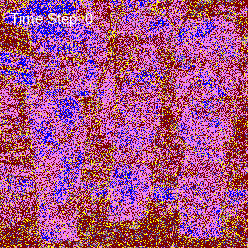

In [105]:
image_dir = 'action_maps_test/0'
image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')])

# Create a list to store images with captions
images_with_captions = []

# Load images and add captions
for i, img_file in enumerate(image_files):
    img = Image.open(img_file)
    
    # Add caption with time steps
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 15)  # Change the font and size if needed
    draw.text((10, 10), f"Time Step: {i}", fill="white", font=font)
    
    images_with_captions.append(img)

# Save the GIF file
images_with_captions[0].save('output.gif', save_all=True, append_images=images_with_captions[1:], duration=1000, loop=0)
display(IPImage(filename='output.gif'))

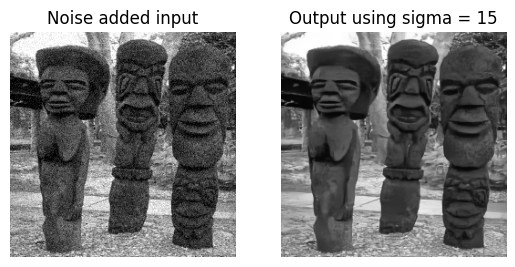

In [28]:
img1 = cv2.imread('./resultimage15/0_input.png')
img2 = cv2.imread('./resultimage15/0_output.png')

fig, ax = plt.subplots(1, 2)

ax[0].imshow(img1)
ax[0].title.set_text('Noise added input')
ax[0].axis('off')
ax[1].title.set_text('Output using sigma = 15')
ax[1].imshow(img2)
ax[0].axis('off')
ax[1].axis('off')

plt.show()

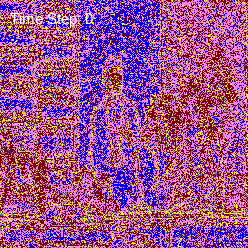

In [106]:
image_dir = 'action_maps_test/10'
image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')])

# Create a list to store images with captions
images_with_captions = []

# Load images and add captions
for i, img_file in enumerate(image_files):
    img = Image.open(img_file)
    
    # Add caption with time steps
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 15)  # Change the font and size if needed
    draw.text((10, 10), f"Time Step: {i}", fill="white", font=font)
    
    images_with_captions.append(img)

# Save the GIF file
images_with_captions[0].save('output.gif', save_all=True, append_images=images_with_captions[1:], duration=1000, loop=0)
display(IPImage(filename='output.gif'))

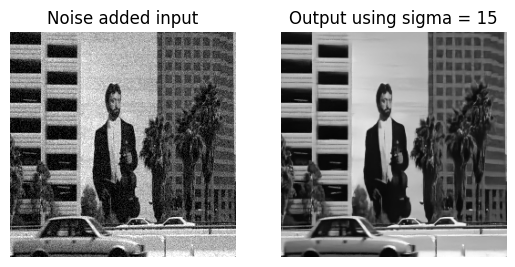

In [29]:
img1 = cv2.imread('./resultimage15/10_input.png')
img2 = cv2.imread('./resultimage15/10_output.png')

fig, ax = plt.subplots(1, 2)

ax[0].imshow(img1)
ax[0].title.set_text('Noise added input')
ax[0].axis('off')
ax[1].title.set_text('Output using sigma = 15')
ax[1].imshow(img2)
ax[0].axis('off')
ax[1].axis('off')

plt.show()

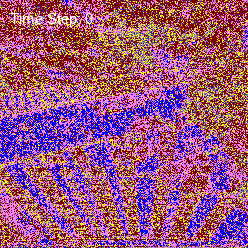

In [109]:
image_dir = 'action_maps_test/20'
image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')])

# Create a list to store images with captions
images_with_captions = []

# Load images and add captions
for i, img_file in enumerate(image_files):
    img = Image.open(img_file)
    
    # Add caption with time steps
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 15)  # Change the font and size if needed
    draw.text((10, 10), f"Time Step: {i}", fill="white", font=font)
    
    images_with_captions.append(img)

# Save the GIF file
images_with_captions[0].save('output.gif', save_all=True, append_images=images_with_captions[1:], duration=1000, loop=0)
display(IPImage(filename='output.gif'))

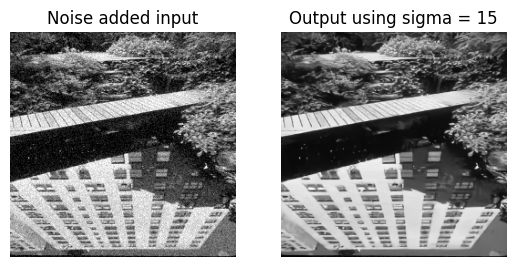

In [30]:
img1 = cv2.imread('./resultimage15/20_input.png')
img2 = cv2.imread('./resultimage15/20_output.png')

fig, ax = plt.subplots(1, 2)

ax[0].imshow(img1)
ax[0].title.set_text('Noise added input')
ax[0].axis('off')
ax[1].title.set_text('Output using sigma = 15')
ax[1].imshow(img2)
ax[0].axis('off')
ax[1].axis('off')

plt.show()

### Testing the model on custom images

In [77]:
test_path = "custom.txt"

mini_batch_loader = MiniBatchLoader(train_path, test_path, image_dir_path, crop_size_)

In [78]:
def test(loader, agent, fout, fout2):
    sum_psnr = 0
    sum_reward = 0
    test_data_size = MiniBatchLoader.count_paths(test_path)
    current_state = State((TEST_BATCH_SIZE,1,crop_size_,crop_size_), MOVE_RANGE)
    for i in range(0, test_data_size, TEST_BATCH_SIZE):
        raw_x = loader.load_testing_data(np.array(range(i, i+TEST_BATCH_SIZE)))
        raw_n = np.random.normal(MEAN,SIGMA,raw_x.shape).astype(raw_x.dtype)/255
        current_state.reset(raw_x,raw_n)
        reward = np.zeros(raw_x.shape, raw_x.dtype)*255
        
        for t in range(0, EPISODE_LEN):
            previous_image = current_state.image.copy()
            action, inner_state = agent.act(current_state.tensor)
            current_state.step(action, inner_state, i, t, fout2, action_color_map)
            reward = np.square(raw_x - previous_image)*255 - np.square(raw_x - current_state.image)*255
            sum_reward += np.mean(reward)*np.power(GAMMA,t)

        agent.stop_episode()
            
        I = np.maximum(0,raw_x)
        I = np.minimum(1,I)
        N = np.maximum(0,raw_x+raw_n)
        N = np.minimum(1,N)
        p = np.maximum(0,current_state.image)
        p = np.minimum(1,p)
        I = (I[0]*255+0.5).astype(np.uint8)
        N = (N[0]*255+0.5).astype(np.uint8)
        p = (p[0]*255+0.5).astype(np.uint8)
        p = np.transpose(p,(1,2,0))
        I = np.transpose(I,(1,2,0))
        N = np.transpose(N,(1,2,0))
        cv2.imwrite('./resultimage_custom/'+str(i)+'_output.png',p)
        cv2.imwrite('./resultimage_custom/'+str(i)+'_input.png',N)

        sum_psnr += cv2.PSNR(p, I)
 
    print("test total reward {a}, PSNR {b}".format(a=sum_reward*255/test_data_size, b=sum_psnr/test_data_size))
    fout.write("test total reward {a}, PSNR {b}\n".format(a=sum_reward*255/test_data_size, b=sum_psnr/test_data_size))
    sys.stdout.flush()

In [79]:
fout = open('log_custom.txt', "w")
fout2 = open('agent_actions_custom.txt', "w")

In [80]:
start = time.time()
test(mini_batch_loader, agent, fout, fout2)
end = time.time()

Agent action for image 0 at time step 0: [[[4 5 4 ... 5 4 0]
  [5 0 1 ... 3 2 4]
  [4 5 5 ... 5 4 4]
  ...
  [5 5 5 ... 5 4 3]
  [4 5 4 ... 5 3 4]
  [5 3 3 ... 5 5 4]]]
Shape of the action: (1, 248, 248)
Agent action for image 0 at time step 1: [[[0 4 0 ... 5 4 4]
  [0 0 0 ... 4 3 4]
  [4 0 5 ... 5 3 4]
  ...
  [4 5 0 ... 5 4 0]
  [1 1 0 ... 4 0 5]
  [4 0 0 ... 0 3 4]]]
Shape of the action: (1, 248, 248)
Agent action for image 0 at time step 2: [[[0 4 4 ... 5 4 3]
  [0 0 0 ... 5 3 0]
  [4 0 5 ... 5 3 4]
  ...
  [4 5 0 ... 0 0 0]
  [0 0 0 ... 5 0 3]
  [0 0 0 ... 0 3 4]]]
Shape of the action: (1, 248, 248)
Agent action for image 0 at time step 3: [[[0 4 0 ... 5 0 3]
  [0 0 0 ... 5 3 3]
  [4 0 5 ... 5 3 4]
  ...
  [4 4 0 ... 0 0 0]
  [0 0 1 ... 5 5 5]
  [0 0 0 ... 2 3 0]]]
Shape of the action: (1, 248, 248)
Agent action for image 0 at time step 4: [[[0 0 0 ... 5 3 3]
  [0 0 0 ... 4 0 0]
  [4 0 0 ... 4 4 4]
  ...
  [0 0 0 ... 0 3 0]
  [0 0 0 ... 0 5 5]
  [0 0 0 ... 5 0 3]]]
Shape of the ac

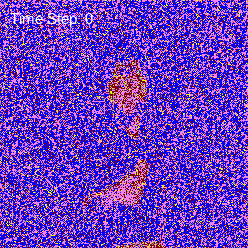

In [92]:
image_dir = 'action_maps_custom/0'
image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')])

# Create a list to store images with captions
images_with_captions = []

# Load images and add captions
for i, img_file in enumerate(image_files):
    img = Image.open(img_file)
    
    # Add caption with time steps
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 15)  
    draw.text((10, 10), f"Time Step: {i}", fill="white", font=font)
    
    images_with_captions.append(img)

# Save the GIF file
images_with_captions[0].save('output.gif', save_all=True, append_images=images_with_captions[1:], duration=1000, loop=0)
display(IPImage(filename='output.gif'))

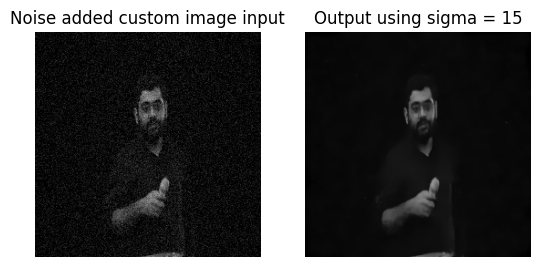

In [48]:
img1 = cv2.imread('./resultimage_custom/0_input.png')
img2 = cv2.imread('./resultimage_custom/0_output.png')

fig, ax = plt.subplots(1, 2)

ax[0].imshow(img1)
ax[0].title.set_text('Noise added custom image input')
ax[0].axis('off')
ax[1].title.set_text('Output using sigma = 15')
ax[1].imshow(img2)
ax[0].axis('off')
ax[1].axis('off')

plt.show()

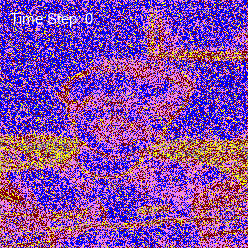

In [89]:
image_dir = 'action_maps_custom/1'
image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')])

# Create a list to store images with captions
images_with_captions = []

# Load images and add captions
for i, img_file in enumerate(image_files):
    img = Image.open(img_file)
    
    # Add caption with time steps
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 15)  # Change the font and size if needed
    draw.text((10, 10), f"Time Step: {i}", fill="white", font=font)
    
    images_with_captions.append(img)

# Save the GIF file
images_with_captions[0].save('output.gif', save_all=True, append_images=images_with_captions[1:], duration=1000, loop=0)
display(IPImage(filename='output.gif'))

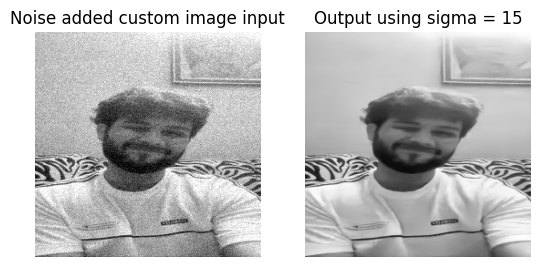

In [49]:
img1 = cv2.imread('./resultimage_custom/1_input.png')
img2 = cv2.imread('./resultimage_custom/1_output.png')

fig, ax = plt.subplots(1, 2)

ax[0].imshow(img1)
ax[0].title.set_text('Noise added custom image input')
ax[0].axis('off')
ax[1].title.set_text('Output using sigma = 15')
ax[1].imshow(img2)
ax[0].axis('off')
ax[1].axis('off')

plt.show()

**END OF B.TECH PROJECT**

---